## 常用库的介绍
### - matplotlib.pyplot
  - 2D绘图库（折线图、散点图、直方图等）。
  - 在脚本中绘图后，通常需要调用 plt.show() 来显示图形。
  - %matplotlib inline是为了内嵌显示图表（不需要单独弹窗）。
### - numpy
  - 多维数组（ndarray） 和数学函数库
  - 数组操作是向量化的，避免使用Python原生for循环遍历数组元素
  - 广播（Broadcasting） 机制允许不同形状的数组进行算术运算
    1.  维度对齐：从尾部开始对齐
    2.  维度相等或其中一个为1：可以广播
    3.  缺失维度视为1
### - pandas
  -  表格型数据结构（DataFrame/Series） 和数据分析工具，核心是数据清洗、处理和分析
  -  DataFrame的索引（index）是其灵魂，可根据某个特征执行对齐操作。
### - statsmodels.api
  - 专注于统计建模、假设检验的库（如线性回归、逻辑回归、时间序列分析）。输出丰富的统计检验报告（如p值、R平方）。
  - 默认不包含截距项，通常需要手动用 sm.add_constant() 为自变量添加常数项。
### - dmatrices
  - 用类似R语言的公式语法（如 "y ~ x1 + x2"）快速为statsmodels或线性模型生成设计矩阵。
  - 它是statsmodels公式接口的底层引擎，通常不单独使用，而是配合statsmodels.formula.api使用。在处理分类变量时，它能自动进行哑变量（Dummy Variable）编码。
### - from sklearn import datasets, svm, ensemble as ske
  - sklearn：机器学习核心库，提供统一API的各类算法、数据预处理和评估工具。sklearn用于预测，输出简洁;statsmodels用于解释，输出详尽的统计指标。
  - datasets：提供经典教学数据集。
  - svm：支持向量机算法模块。
  - ensemble：集成学习算法模块（如随机森林ske.RandomForestClassifier、梯度提升树）。
### - from sklearn.model_selection import cross_val_predict
  - 交叉验证：对数据的每个样本，返回其在交叉验证折叠中作为测试集时得到的预测值。常用于模型评估（如得到全数据集的公平预测以绘制学习曲线）和集成学习的元特征生成。
  - 严禁将这些预测值用于训练模型，否则会导致严重的数据泄露，高估模型性能。

In [8]:
# 导入所有需要的库
import matplotlib.pyplot as plt
# 魔法命令必须独占一行，用于在Notebook内显示图表
%matplotlib inline
import numpy as np
import pandas as pd

# 导入statsmodels库用于逻辑回归
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate

# 导入patsy库，用于将公式转换为模型能理解的数据格式
from patsy import dmatrices

# 导入scikit-learn库，用于支持向量机和随机森林等机器学习算法
from sklearn import datasets, svm
from sklearn import ensemble as ske
from sklearn.model_selection import cross_val_predict  # 【重要】我们将用这个函数替代原Notebook中的KaggleAux.predict

print("所有库导入成功！")

所有库导入成功！


In [9]:
# 使用pandas的read_csv函数读取训练数据
df = pd.read_csv("train.csv") 

# 查看数据框的前几行，确认加载成功
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 数据清洗
### 一般数据清洗过程
- 查看数据缺失情况：isnull
- 针对不同变量类型和缺失情况，采取不同策略处理缺失值
  - 主要考虑因素：（1）缺失值占比；（2）数据分布；（3）数据类型
  - ![缺失值处理决策流程图](./projects/1-titanic/images/1-数据清洗决策流程图.png)
- 处理后，再查数据缺失情况：isnull
### 本题解析
- 删除Cabin列
  - 高基数分类
  - 缺失率＞50%。填充会导致大量虚假信息
- 年龄（Age）用中位数填充
  - 数值型变量+缺失率约20%
  - 数据分布有偏时，使用中位数填充比平均数更稳健，不易受极端值影响；若分布正态可用均值填充
- Embarked（登船港口）用众数填充
  - 低基数分类变量+缺失极少
  - 众数保证填充值与整体分布一致
- Ticket（船票号）直接删除列（但非因缺失）
  - 信息杂乱 + 提取复杂，对预测帮助不大 → 在基础清洗中删除

In [ ]:
# ========== 数据清洗步骤 ==========
print("开始数据清洗...")

# 1. 首先，我们查看一下整个数据集各列的缺失值情况
print("\n1. 原始数据各列缺失值数量:")
print(df.isnull().sum())

# 2. 处理 Cabin（船舱）列：缺失值太多（687个），直接删除此列
# df是dataframe的缩写；df.调用功能
# ['']：参数-指定要删除的列名
# axis: axis=0 表示操作行，axis=1 表示操作列
# f = ...：将删除列后的新DataFrame赋值回变量df，覆盖原数据。如果不赋值，原df不会改变。
df = df.drop(['Cabin'], axis=1)
print("\n2. 已删除 'Cabin' 列。")

# 3. 处理 Age（年龄）列：用中位数填充缺失值，这样不会受极端年龄影响
age_median = df['Age'].median()  # 计算所有年龄的中位数
df['Age'] = df['Age'].fillna(age_median)  # 用中位数填充NaN
print(f"3. 已将 {df['Age'].isnull().sum()} 个年龄缺失值填充为: {age_median:.1f} 岁")  # 格式控制：将age_median变量格式化为浮点数，保留1位小数。


# 4. 处理 Embarked（登船港口）列：只有2个缺失，用最常见的港口填充
most_common_port = df['Embarked'].mode()[0]  # mode()是取众数，即出现次数最多的值。计算Embarked列的众数（出现频率最高的值），返回一个Series。通过索引 [0] 从mode()返回的Series中取出第一个（也是唯一/最主要的）众数值。
df['Embarked'] = df['Embarked'].fillna(most_common_port)
print(f"4. 已将 {df['Embarked'].isnull().sum()} 个登船港口缺失值填充为: '{most_common_port}'")

# 5. （可选但常见做法）删除 Ticket（船票号）列，信息杂乱，对预测帮助不大
df = df.drop(['Ticket'], axis=1)
print("5. 已删除 'Ticket' 列。")

# 6. 再次检查，确认所有缺失值已处理完毕
print("\n6. 清洗完成！最终数据缺失情况:")
print(df.isnull().sum())

print(f"\n✅ 最终数据形状: {df.shape}")
print("✅ 数据清洗完成，可以进行分析了！")

开始数据清洗...

1. 原始数据各列缺失值数量:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

2. 已删除 'Cabin' 列。
3. 已将 0 个年龄缺失值填充为: 28.0 岁
4. 已将 0 个登船港口缺失值填充为: 'S'
5. 已删除 'Ticket' 列。

6. 清洗完成！最终数据缺失情况:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

✅ 最终数据形状: (891, 10)
✅ 数据清洗完成，可以进行分析了！


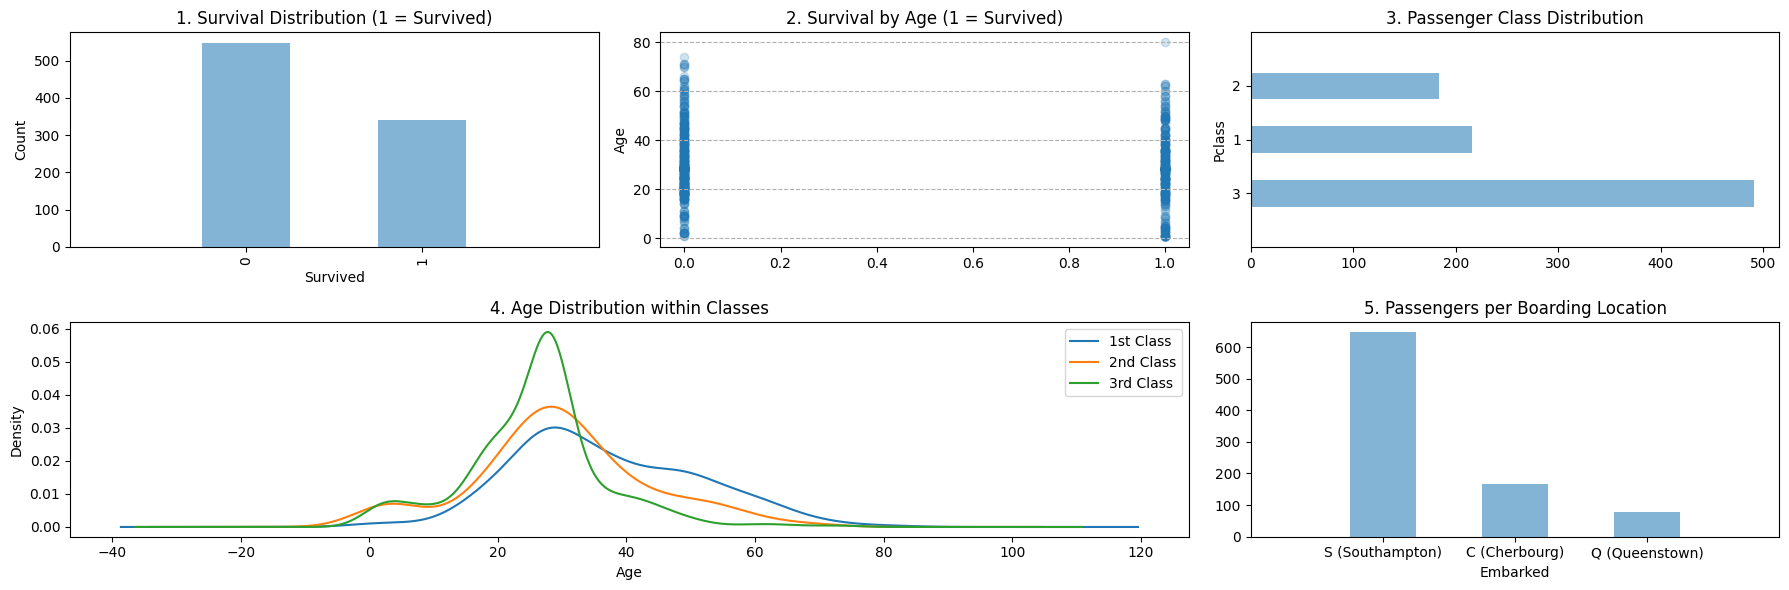

In [11]:
# Set figure parameters
fig = plt.figure(figsize=(18, 6))
alpha_scatterplot = 0.2
alpha_bar_chart = 0.55

# ---------- Chart 1: Survival Distribution (Top-left) ----------
ax1 = plt.subplot2grid((2, 3), (0, 0))
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax1.set_xlim(-1, 2)
plt.title("1. Survival Distribution (1 = Survived)", fontsize=12)
plt.ylabel("Count")

# ---------- Chart 2: Survival by Age Scatter (Top-middle) ----------
plt.subplot2grid((2, 3), (0, 1))
plt.scatter(df.Survived, df.Age, alpha=alpha_scatterplot)
plt.ylabel("Age")
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.title("2. Survival by Age (1 = Survived)", fontsize=12)

# ---------- Chart 3: Passenger Class Distribution (Top-right) ----------
ax3 = plt.subplot2grid((2, 3), (0, 2))
df.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("3. Passenger Class Distribution", fontsize=12)

# ---------- Chart 4: Age Distribution by Class (Bottom-left, spans 2 cols) ----------
plt.subplot2grid((2, 3), (1, 0), colspan=2)
df.Age[df.Pclass == 1].plot(kind='kde', label='1st Class')
df.Age[df.Pclass == 2].plot(kind='kde', label='2nd Class')
df.Age[df.Pclass == 3].plot(kind='kde', label='3rd Class')
plt.xlabel("Age")
plt.title("4. Age Distribution within Classes", fontsize=12)
plt.legend(loc='best')

# ---------- Chart 5: Embarkation Port Distribution (Bottom-right) ----------
ax5 = plt.subplot2grid((2, 3), (1, 2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
plt.title("5. Passengers per Boarding Location", fontsize=12)
# Add port labels (S=Southampton, C=Cherbourg, Q=Queenstown)
ports = ['S (Southampton)', 'C (Cherbourg)', 'Q (Queenstown)']
ax5.set_xticklabels(ports[:len(df.Embarked.value_counts())], rotation=0)

plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

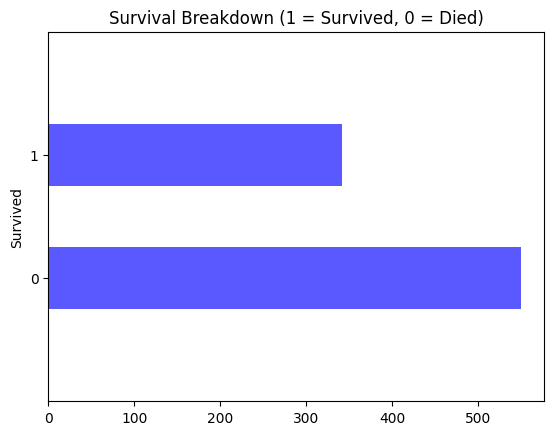

遇难 (0): 549 人
幸存 (1): 342 人
总体生存率: 38.38%


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
# 原Notebook中"Exploratory Visualization"部分的第一段代码
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
df.Survived.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(df.Survived.value_counts()))
plt.title("Survival Breakdown (1 = Survived, 0 = Died)")
plt.show()

# 打印具体数字
survival_counts = df.Survived.value_counts()
print(f"遇难 (0): {survival_counts[0]} 人")
print(f"幸存 (1): {survival_counts[1]} 人")
print(f"总体生存率: {survival_counts[1] / len(df):.2%}")

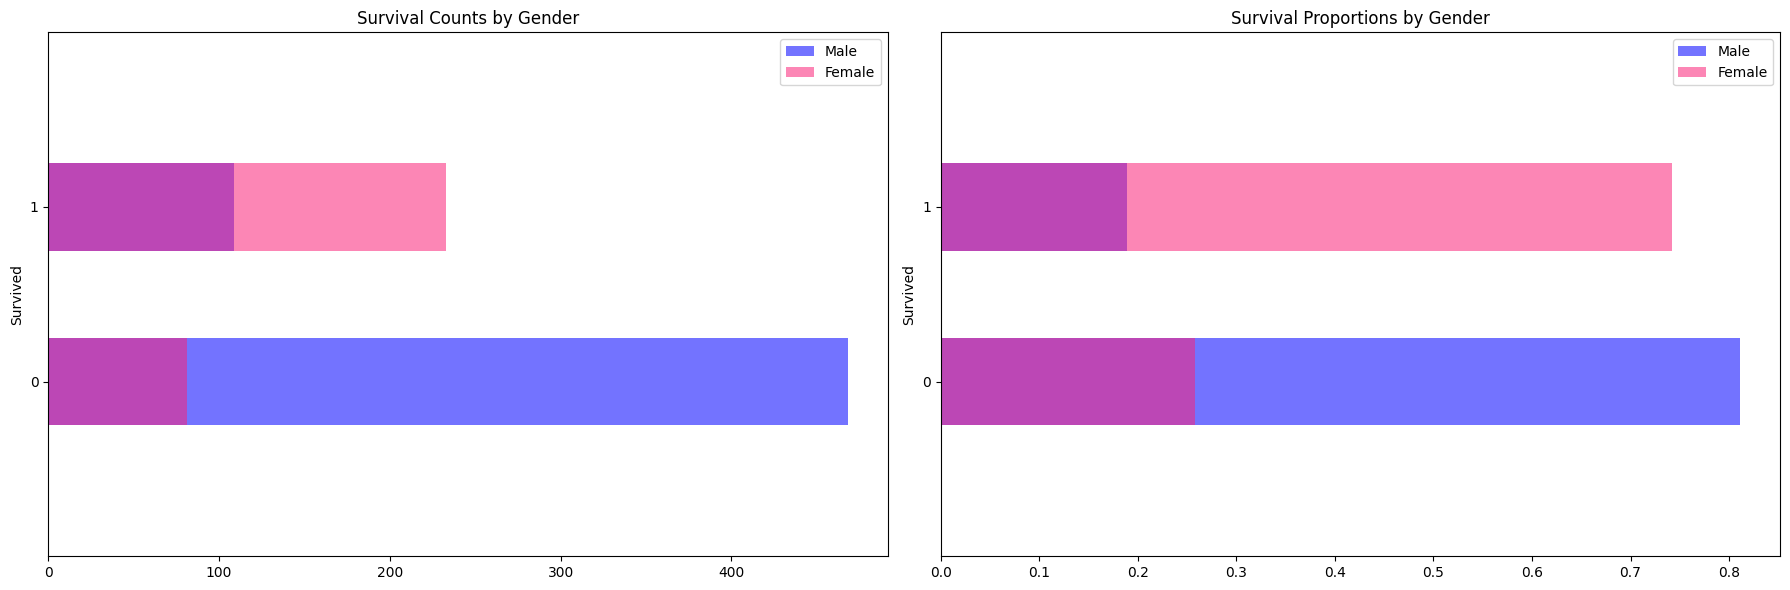

男性生存情况:
  死亡: 468 人, 幸存: 109 人
  生存率: 18.89%

女性生存情况:
  死亡: 81 人, 幸存: 233 人
  生存率: 74.20%


In [13]:
# 原Notebook中按性别分析的部分
fig = plt.figure(figsize=(18,6))

# 创建两个子图，左边显示原始人数，右边显示比例

# 左边子图：男性和女性的生存/死亡原始人数
df_male = df.Survived[df.Sex == 'male'].value_counts().sort_index()
df_female = df.Survived[df.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
df_male.plot(kind='barh', label='Male', alpha=0.55, color='blue')
df_female.plot(kind='barh', color='#FA2379', label='Female', alpha=0.55)
plt.title("Survival Counts by Gender")
plt.legend(loc='best')
ax1.set_ylim(-1, 2)

# 右边子图：男性和女性的生存比例
ax2 = fig.add_subplot(122)
(df_male / float(df_male.sum())).plot(kind='barh', label='Male', alpha=0.55, color='blue')
(df_female / float(df_female.sum())).plot(kind='barh', color='#FA2379', label='Female', alpha=0.55)
plt.title("Survival Proportions by Gender")
plt.legend(loc='best')
ax2.set_ylim(-1, 2)

plt.tight_layout()
plt.show()

# 打印计算过程
print("男性生存情况:")
print(f"  死亡: {df_male[0]} 人, 幸存: {df_male[1]} 人")
print(f"  生存率: {df_male[1] / df_male.sum():.2%}\n")

print("女性生存情况:")
print(f"  死亡: {df_female[0]} 人, 幸存: {df_female[1]} 人")
print(f"  生存率: {df_female[1] / df_female.sum():.2%}")

## 建模
### 定义模型公式
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + C(Embarked)'
生存概率 = α + β₁×舱位等级 + β₂×性别 + β₃×年龄 + β₄×兄弟姐妹数 + β₅×登船港口
* 为什么用C()标记分类变量？
    假设Sex列的值是：'male', 'female'，如果不标记为分类变量，模型可能错误地认为：male=1, female=2 → 女性比男性"大"（错误！）
    使用C()后，模型会正确创建哑变量：
    - Sex_male: [1, 0, 1...]    # 是男性=1，不是=0
    - Sex_female: [0, 1, 0...]  # 是女性=1，不是=0
###   准备模型数据
原始df 
= [
    [1, 'male', 22, 1, 'S'],    # 舱位3等，男性，22岁，1个兄弟姐妹，S港登船
    [2, 'female', 38, 1, 'C'],  # 舱位2等，女性，38岁，1个兄弟姐妹，C港登船
]
x矩阵（特征） 
= [
    [1, 0, 0,   0, 1,   22, 1,   1, 0, 0],  # 第一行转换后
    [0, 1, 0,   1, 0,   38, 1,   0, 1, 0],  # 第二行转换后
]
y向量（目标） 
= [0, 1]  # 是否生还
### 创建并训练模型（核心计算）
* Logit模型是什么？
  * 逻辑回归的核心公式：P = 1 / (1 + e^(-z))，其中 z = β₀ + β₁X₁ + β₂X₂ + ...
  * 简单理解：把线性回归的结果通过"S型曲线"映射到0-1之间，这样就能得到"生还概率"而不是直接的数值。
* 训练过程（fit()在做什么）
  1. 初始化：随机给每个特征一个权重（β值）
  2. 计算误差：用当前权重预测，看预测值与真实值的差距
  3. 调整权重：向减少误差的方向微调权重
  4. 重复：直到误差最小或达到最大迭代次数
* 解读模型摘要关键指标
  1. 系数（coef）
     -  正系数 → 增加生还概率；负系数 → 降低生还概率
     -  C(Sex)[T.male] = -2.5228  # 男性比女性生还概率显著降低（符合历史）
  2. P值（P>|z|） - 显著性检验
     -  P值 < 0.05 → 特征显著（对预测有作用）
     -  C(Embarked)[T.Q] P值=0.971 > 0.05  # 登船港口Q可能不影响生还
  3. 置信区间
     -  系数的可靠范围；如果不包含0，说明效应确定存在
     -  Age的区间: [-0.053, -0.023]  # 不包含0 → 年龄效应确定存在

In [14]:
# ========== 第一步：定义模型公式 ==========
# 我们使用patsy库的公式语法，类似R语言，非常直观
# ~ 左边是我们要预测的目标（Survived），右边是用于预测的特征
# C() 表示该特征是分类变量（如Pclass、Sex、Embarked）
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + C(Embarked)'

# 创建一个字典来保存模型结果，方便后续比较
results = {}

# ========== 第二步：准备模型数据 ==========
# dmatrices函数会根据公式，自动将数据转换为模型所需的矩阵格式，并处理好分类变量
y, x = dmatrices(formula, data=df, return_type='dataframe')
print("模型数据准备完毕。")
print(f"  特征矩阵 (x) 形状: {x.shape}")
print(f"  目标变量 (y) 形状: {y.shape}")

# ========== 第三步：创建并训练模型 ==========
model = sm.Logit(y, x)  # 使用statsmodels库创建逻辑回归模型
res = model.fit()       # 在数据上拟合模型，寻找最优参数

# ========== 第四步：保存结果并查看模型摘要 ==========
results['Logit'] = [res, formula]  # 保存到字典
print("\n模型训练完成！以下是详细的统计摘要：")
print("="*60)
res.summary()

模型数据准备完毕。
  特征矩阵 (x) 形状: (891, 8)
  目标变量 (y) 形状: (891, 1)
Optimization terminated successfully.
         Current function value: 0.441283
         Iterations 6

模型训练完成！以下是详细的统计摘要：


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Sat, 07 Feb 2026   Pseudo R-squ.:                  0.3373
Time:                        07:16:38   Log-Likelihood:                -393.18
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.068e-82
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.2235      0.419     10.086      0.000       3.403       5.044
C(Pclass)[T.2]      -1.0396      0.270     -3.857      0.000      -1.568      -0.511
C(Pclass)[T.3]      -2.3024      0.255     -9.046      0.000      -2.801      -1.804
C(Sex)[T.male]      -2.6994      0.195    -13.814      0.000      -3.082      -2.316
C(Embarked)[T.Q]    -0.0559      0.378     -0.148      0.883      -0.797       0.685
C(Embarked)[T.S]    -0.4678      0.236     -1.981      0.048      -0.931      -0.005
Age                 -0.0387      0.008     -4.954      0.000      -0.054      -0.023
SibSp               -0.3272      0.104     -3.155      0.002      -0.530      -0.124
====================================================================================
"""

## 模型可视化诊断
### 左图：模型准确度检查
- 信息1：模型整体预测能力
  - 理想情况：当实际值=1（生还）时，预测概率应该接近1（红色点在顶部时蓝色点也在顶部）；当实际值=0（遇难）时，预测概率应该接近0（红色点在底部时蓝色点也在底部）
  - 现实情况：我们想看到明显的"分层"
    - 生还者（y=1）的预测概率集中在0.6-1.0
    - 遇难者（y=0）的预测概率集中在0-0.4
- 信息2：识别预测错误的乘客
  - 是否需要更多特征？
  - 是否有数据质量问题？
  - 模型复杂度是否合适？
- 信息3：预测概率的分布情况
  - 健康信号：预测值大部分集中在两端（接近0或1），说明模型有信心做出明确判断
  - 预测值大量集中在0.5附近，说明模型犹豫不决，缺乏区分能力。可能特征不够强，或者样本重叠严重。
### 右图：残差图检测预测完整性
- 什么是残差？
  - 对于每个乘客：残差 = 实际是否生还(0/1) - 预测生存概率(0-1)
  - 理想残差：应该随机分布在0附近，没有明显规律
- 关键信息
  - 信息1：检查残差是否随机（最重要！）
    - 问题模式1：有趋势（如从左到右上升/下降）
      - 说明还有系统性规律未被模型学习
      - 可能原因：遗漏了重要特征，或特征组合
    - 问题模式2：有周期性波动
      - 说明数据中有周期性规律未被捕获
    - 问题模式3：漏斗形（一端分散一端集中）
      - 方差不齐，可能需要变换变量或使用稳健回归
  - 信息2：识别异常残差（离群点）
  - 信息3：检查残差分布是否对称
    - 健康：残差大致对称分布在0线两侧
    - 问题：明显偏向一侧（如大部分残差为正），说明模型有系统性偏差（总是高估或低估）

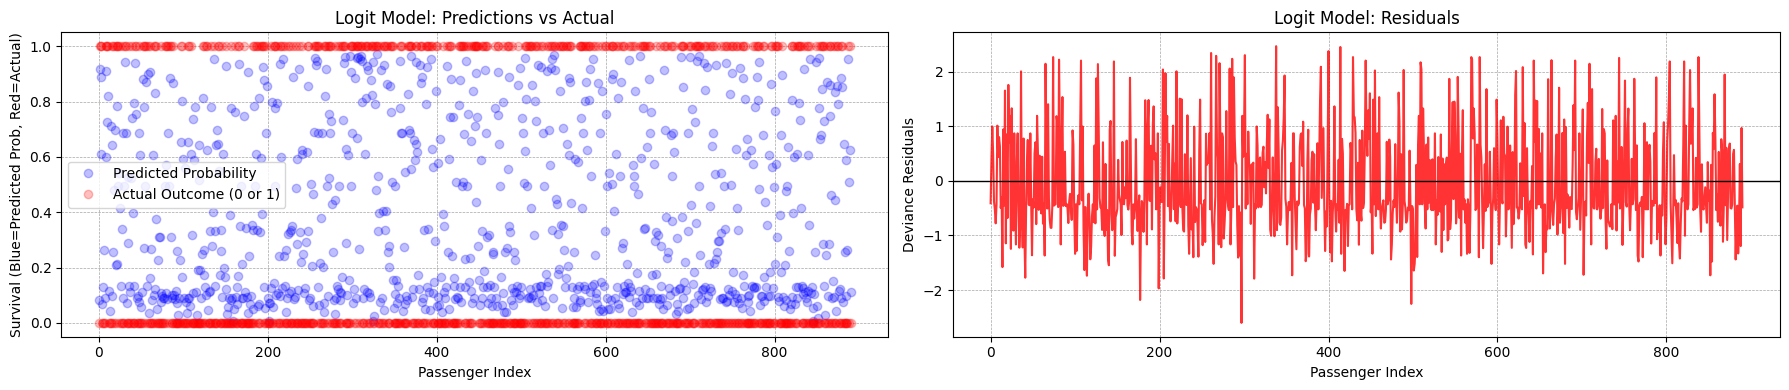

In [15]:
# ========== 可视化模型预测与残差 ==========
plt.figure(figsize=(18,4))

# 左图：模型预测值 vs 实际值
plt.subplot(1, 2, 1)
ypred = res.predict(x)  # 模型对训练集预测的生存概率 (0到1之间)
plt.plot(x.index, ypred, 'bo', label='Predicted Probability', alpha=.25)
plt.plot(x.index, y, 'ro', label='Actual Outcome (0 or 1)', alpha=.25)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Logit Model: Predictions vs Actual')
plt.xlabel('Passenger Index')
plt.ylabel('Survival (Blue=Predicted Prob, Red=Actual)')
plt.legend()

# 右图：模型残差图（检查是否还有规律未被学习）
plt.subplot(1, 2, 2)
plt.plot(res.resid_dev, 'r-', alpha=0.8)  # 残差应该随机分布，没有明显模式
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Logit Model: Residuals')
plt.xlabel('Passenger Index')
plt.ylabel('Deviance Residuals')
plt.axhline(y=0, color='k', linestyle='-', linewidth=1) # 在y=0处画一条参考线

plt.tight_layout()
plt.show()

## 测试集预测
1. 加载测试数据
   - 读取测试集文件，确保路径正确
   - 验证数据加载成功：查看形状和前几行数据
   - 测试集只有特征，没有目标变量（这是我们预测的目标）
2. 数据清洗处理
   - 核心原则：与训练集处理方式完全一致
   - 必须一致的项目
     - 删除相同的列
     - 相同的缺失值填充方法
     - 相同的特征工程处理
   - 关键注意事项
     - 严禁数据泄露：使用训练集的统计量（中位数、众数等）填充测试集缺失值
     - 禁止使用测试集自身的统计量计算填充值
3. 特征准备
   - 为测试集创建目标变量占位列（值会被覆盖）
   - 使用与训练集完全相同的公式准备特征矩阵
   - 确保特征编码、转换完全一致
4. 模型预测
   - 使用训练好的模型对象（res）对测试集进行预测
   - 得到的是连续概率值（0到1之间）
   - 验证预测结果在合理范围内
5. 转换为分类结果
   - 设置阈值（通常为0.5）
   - 将概率转换为0/1分类结果
   - 可根据业务需求调整阈值
6. 准备提交文件
   - 选择要求的列（通常为ID和预测值）
   - 保存为CSV格式
   - 确保格式符合比赛要求

常见错误提醒
1. 数据泄露：使用测试集计算填充值 ❌
2. 特征不一致：测试集缺少训练时使用的特征 ❌
3. 编码不一致：分类变量编码方式不同 ❌
4. 忘记删除相同列：测试集包含训练时删除的列 ❌
5. 文件格式错误：包含索引、列名错误 ❌

In [ ]:
# ========== 1. 加载测试数据 ==========
test_df = pd.read_csv("test.csv")  # 确保test.csv文件在data文件夹中
print(f"测试数据加载成功！形状: {test_df.shape}")
print(test_df.head())

# ========== 2. 对测试数据进行相同的清洗 ==========
# 注意：必须使用与训练集完全相同的处理方式！
test_df_clean = test_df.copy()

# 删除相同的列
test_df_clean = test_df_clean.drop(['Cabin', 'Ticket'], axis=1)

# 填充缺失值：使用训练集计算的中位数和众数，而不是测试集本身的
# 这是为了防止“数据泄露”，非常重要！
test_df_clean['Age'].fillna(df['Age'].median(), inplace=True)  # 用训练集的年龄中位数
test_df_clean['Fare'].fillna(df['Fare'].median(), inplace=True)  # 测试集Fare有1个缺失，用训练集票价中位数；inplace=True ← 直接修改原数据
test_df_clean['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)  # 用训练集的登船港口众数

print("\n测试数据清洗完成！")
print("缺失值检查:")
print(test_df_clean.isnull().sum())

# ========== 3. 使用模型进行预测 ==========
# 注意：我们使用之前训练好的模型对象 `res` 和公式 `formula`
# 为测试集创建一个“Survived”列占位（模型需要，但值会被覆盖）
test_df_clean['Survived'] = 0

# 使用相同的公式为测试集准备数据
test_y, test_x = dmatrices(formula, data=test_df_clean, return_type='dataframe')

# 进行预测！得到的是生存概率 (0到1之间)
test_predictions = res.predict(test_x)
print(f"\n生成预测完成！共得到 {len(test_predictions)} 条预测结果。")
print("前10位乘客的生存概率示例:")
print(test_predictions.head(10).values)

# ========== 4. 将概率转换为二分类结果 (0或1) ==========
# 通常以0.5为阈值：概率>=0.5预测为生存(1)，否则为死亡(0)
test_df_clean['Survived'] = (test_predictions >= 0.5).astype(int)

# ========== 5. 准备Kaggle提交文件 ==========
# Kaggle只需要两列：PassengerId 和 Survived
submission = test_df_clean[['PassengerId', 'Survived']]
submission_file_path = "submission_logit.csv"  # 保存到当前工作目录
submission.to_csv(submission_file_path, index=False)

print("="*60)
print(f"✅ 预测完成！提交文件已保存至: {submission_file_path}")
print(f"文件内容预览:")
print(submission.head(10))
print(f"\n生存预测统计: 预测 {submission['Survived'].sum()} 人幸存, {len(submission)-submission['Survived'].sum()} 人遇难。")

测试数据加载成功！形状: (418, 11)
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  

测试数据清洗完成！
缺失值检查:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0


C:\Users\qzy\AppData\Local\Temp\ipykernel_8556\2748564355.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df_clean['Age'].fillna(df['Age'].median(), inplace=True)  # 用训练集的年龄中位数
C:\Users\qzy\AppData\Local\Temp\ipykernel_8556\2748564355.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha